# Train Energy Regressor

This notebook demonstrates how to train the `ctapipe` included (energy) regressor on a given set of features. These features were selected and written out by the `write_feature_table.py` script.  
Consecutively, the training is validated on a new set of events in an event-loop as you might use it during the normal reconstruction run.

In [1]:
from ipywidgets import interact, widgets

from os.path import expandvars

from collections import namedtuple
from glob import glob

# PyTables
import tables as tb

from ctapipe.io.hessio import hessio_event_source

from ctapipe.utils import linalg
from ctapipe.utils.CutFlow import CutFlow

from ctapipe.reco.energy_regressor import *

from ctapipe.reco.HillasReconstructor import \
    HillasReconstructor, TooFewTelescopes

from modules.prepare_event import EventPreparer
from modules.ImageCleaning import ImageCleaner

from helper_functions import *

%matplotlib inline

# your favourite units here
energy_unit = u.TeV
angle_unit = u.deg
dist_unit = u.m

## Training
The regressor can train a separate model for the various camera types. The energy prediction then takes these different camera types into account.  
Define here a list of `cam_id`s the regressor is supposed to build a model for.

In [2]:
# for which cam_id to generate a model
cam_id_list = [
        # 'GATE',
        # 'HESSII',
        'NectarCam',
        'LSTCam',
        'DigiCam',
        # 'SST-1m',
        # 'FlashCam',
        # 'ASTRICam',
        # 'SCTCam',
        ]

# the list of features to train the model on
EnergyFeatures = namedtuple(
    "EnergyFeatures", (
        "impact_dist",
        "sum_signal_evt",
        "max_signal_cam",
        "sum_signal_cam",
        "N_LST",
        "N_MST",
        "N_SST",
        "width",
        "length",
        "skewness",
        "kurtosis",
        "h_max",
        "err_est_pos",
        "err_est_dir"
    ))

### Setting up the feature and target dictionaries
Read in a file with all the feature tables that was previously written by another script. The features are collected in a dictionary with the `cam_id`s as keys. The values are the lists of "feature-lists". Every "feature-list" corresponds to one camera image and collects camera-based (e.g. the Hillas parameters) and event-based (e.g. reconstructed h_max) iniformation.
The same for the energies: For every dictionary key (i.e. the camera IDs), a list of the Monte Carlo energies is collected, corresponding to the camera-events in the `features` dictionary.  
  
Naturally, the keys in `features` and `energies` ought to be the same...

In [3]:
features_filename = widgets.Textarea(
    value="data/features_wave_gamma.h5",
    placeholder='Name of the data file to read',
    description='features file name',
    disabled=False
)
features_filename

In [4]:
features_file = tb.open_file(features_filename.value, mode="r")

features = {"LSTCam": [[row[name] for name in EnergyFeatures._fields] for row in
                       features_file.root.feature_events_lst],
            "DigiCam": [[row[name] for name in EnergyFeatures._fields] for row in
                        features_file.root.feature_events_dig],
            "NectarCam": [[row[name] for name in EnergyFeatures._fields] for row in
                          features_file.root.feature_events_nec]}

energies = {"LSTCam": np.array([row["MC_Energy"] for row in
                                features_file.root.feature_events_lst]) * energy_unit,
            "DigiCam": np.array([row["MC_Energy"] for row in
                                 features_file.root.feature_events_dig]) * energy_unit,
            "NectarCam": np.array([row["MC_Energy"] for row in
                                   features_file.root.feature_events_nec]) * energy_unit}

This is how the `feature_file` and the included tables look like:

In [5]:
import pandas as pd

# print the list of tables in the file
for table in features_file:
    print(table)

# print the content of one of the tables
pd.read_hdf("data/features_wave_gamma.h5", "feature_events_lst",
            mode="r")[:10]

/ (RootGroup) ''
/feature_events_dig (Table(46950,)) ''
/feature_events_lst (Table(63194,)) ''
/feature_events_nec (Table(112077,)) ''


,impact_dist,sum_signal_evt,max_signal_cam,sum_signal_cam,N_LST,N_MST,N_SST,width,length,skewness,kurtosis,h_max,err_est_pos,err_est_dir,MC_Energy
0,241.533173,615.136719,32.453178,172.498245,3,4,0,0.024710,0.084085,-0.517021,2.724738,9669.419922,7.352174e+00,1.000358,0.066580
1,181.500900,615.136719,28.845568,151.116287,3,4,0,0.037945,0.056210,0.674897,3.111790,9669.419922,7.352174e+00,1.000358,0.066580
2,125.332985,615.136719,31.058037,129.105713,3,4,0,0.032228,0.059420,1.328111,6.490304,9669.419922,7.352174e+00,1.000358,0.066580
3,321.746063,160.429382,9.972353,29.009722,3,0,0,0.023534,0.037846,0.504398,2.610255,8787.000977,3.108760e-14,0.000000,0.023017
4,376.702942,160.429382,27.570141,131.419662,3,0,0,0.024795,0.075991,-0.103438,1.906798,8787.000977,3.108760e-14,0.000000,0.023017
5,5677.963379,106.206497,5.052133,23.550303,1,1,0,0.026086,0.036092,-0.148767,1.980181,8961.821289,2.427679e-13,0.000000,0.104140
6,149.883987,196.503067,7.037348,78.265152,1,3,0,0.039186,0.069314,0.083565,2.358448,13737.394531,1.582609e+01,3.801294,0.125729
7,374.968201,6554.309570,27.677361,393.861206,3,9,2,0.038073,0.132947,-0.822593,2.954179,8863.172852,2.557224e-01,1.136736,1.509072
8,468.265594,6554.309570,7.170481,81.878456,3,9,2,0.025738,0.144876,-0.359281,1.782578,8863.172852,2.557224e-01,1.136736,1.509072
9,430.516266,6554.309570,14.449444,132.417587,3,9,2,0.026210,0.096906,-0.285569,2.016702,8863.172852,2.557224e-01,1.136736,1.509072


### Defining and training the model
The dictionary `clf_kwargs` sets up the behaviour of the `EnergyRegressor`. An optional "regressor" argument could be given to change the type of model to be created. The argument needs to be a class that has to comply to the scikit-learn typical interface.
If not given, the default is "RandomForestRegressor".  
The "cam_id_list" argument contains the list of names for which to generate a model.  
All other arguments are handed over to the class given in "regressor".

In [6]:
# use default random forest regressor
reg_kwargs = {'n_estimators': 40, 'max_depth': None,
              'min_samples_split': 2, 'random_state': 0,
              'cam_id_list': cam_id_list}

construct the regressor object and train it on the given `features` and `energies`

In [7]:
reg = EnergyRegressor(**reg_kwargs)
reg.fit(features, energies)

The importance of the given features to the energy estimation can be shown like this:

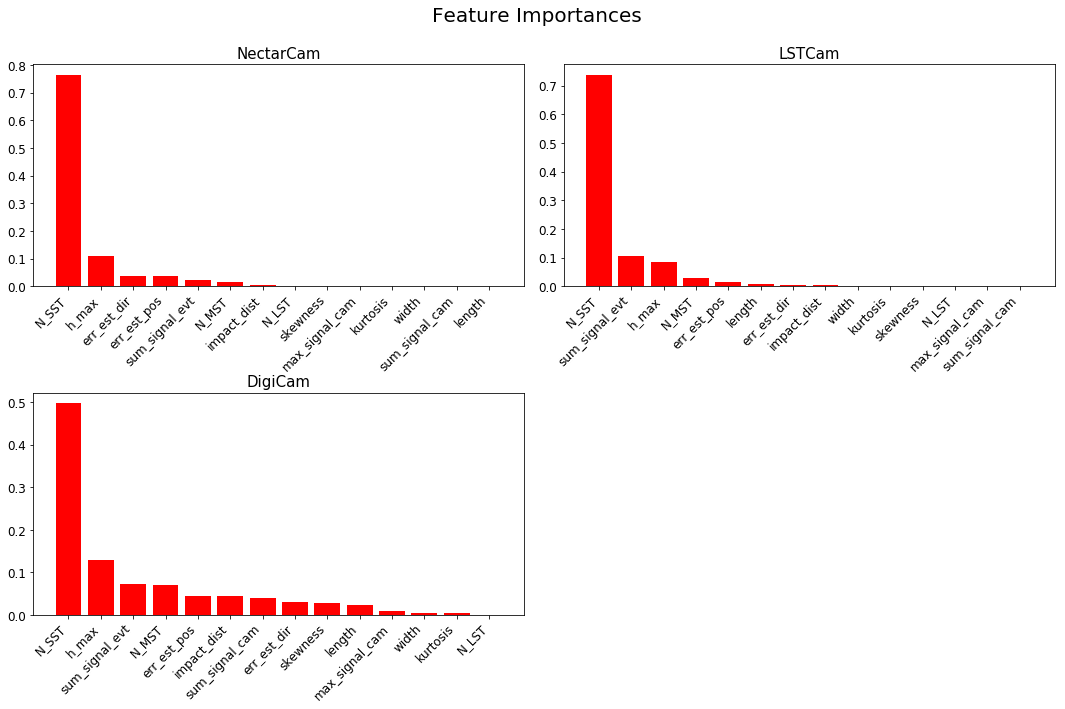

In [8]:
fig = reg.show_importances(EnergyFeatures._fields)
fig.set_size_inches(15, 10)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    for label in ax.get_xmajorticklabels():
        label.set_horizontalalignment("right")
plt.subplots_adjust(top=0.9, bottom=0.135, left=0.034, right=0.98,
                    hspace=0.478, wspace=0.08)
plt.show()

### Saving the model
To save the models to disc, provide a filename as a string which contains "{cam_id}". This token gets replaced by the previously given camera names, so the models are saved separately for the different camera types.

In [9]:
reg.save("models/regressor_{cam_id}.pckl")
glob("models/*")

['models/regressor_LSTCam.pckl',
 'models/regressor_NectarCam.pckl',
 'models/regressor_DigiCam.pckl']

## Cross validation
To check the performance of the trained models, load a new set of gamma events, process them as usual (cf. `EventPreparer`), predict the energy and in the end compare predicted with the simulated energy

### Setup for reconstruction
Here, some base classes are constructed that perform the standard image cleaning, shower reconstructien, event selection etc.

In [10]:
# keeping track of events and where they were rejected
Eventcutflow = CutFlow("EventCutFlow")
Imagecutflow = CutFlow("ImageCutFlow")

# takes care of image cleaning
cleaner = ImageCleaner(mode="wave", cutflow=Imagecutflow,
                       wavelet_options=None,
                       skip_edge_events=True, island_cleaning=True)

# the class that does the shower reconstruction
shower_reco = HillasReconstructor()

preper = EventPreparer(
    cleaner=cleaner, shower_reco=shower_reco,
    event_cutflow=Eventcutflow, image_cutflow=Imagecutflow,
    # event/image cuts:
    allowed_cam_ids=[],  # [] or None means: all
    min_ntel=2,
    min_charge=25, min_pixel=3)

Imagecutflow.add_cut("features nan", lambda x: np.isnan(x).any())

### Event Loop
Reading in the new gamma files and do the event loop: reconstruct the shower, collect the features and predict the energy.

In [11]:
import pyhessio
import datetime

energy_mc, energy_rec, energy_rec_cam = [], [], []

def event_loop(input_data, n_files=1, max_events=10):
    
    print("last function call:", datetime.datetime.now())
    
    # close open files and reset some arrays in case we run `interact`
    # in the next cell several times 
    try:
        pyhessio.close_file()
    except:
        pass

    global energy_mc 
    global energy_rec 
    global energy_rec_cam 
    energy_mc, energy_rec, energy_rec_cam = [], [], []
   
    # reading input files and doing event loop
    filenamelist_gamma = sorted(glob(input_data))
    allowed_tels = prod3b_tel_ids("L+N+D")
    for i, filename in enumerate(filenamelist_gamma[:n_files]):

        print(f"{i} -- filename = {filename}")

        source = hessio_event_source(filename,
                                     allowed_tels=allowed_tels,
                                     max_events=max_events)

        # loop that cleans and parametrises the images
        # and performs the reconstruction
        for (event, hillas_dict, n_tels,
             tot_signal, max_signals, pos_fit, dir_fit, h_max,
             err_est_pos, err_est_dir) in preper.prepare_event(source):

            # now prepare the features for the classifier
            cls_features_evt = {}
            reg_features_evt = {}
            for tel_id in hillas_dict.keys():
                Imagecutflow.count("pre-features")

                tel_pos = np.array(event.inst.tel_pos[tel_id][:2]) * u.m

                moments = hillas_dict[tel_id]

                impact_dist = linalg.length(tel_pos - pos_fit)

                reg_features_tel = EnergyFeatures(
                    impact_dist=impact_dist / u.m,
                    sum_signal_evt=tot_signal,
                    max_signal_cam=max_signals[tel_id],
                    sum_signal_cam=moments.size,
                    N_LST=n_tels["LST"],
                    N_MST=n_tels["MST"],
                    N_SST=n_tels["SST"],
                    width=moments.width / u.m,
                    length=moments.length / u.m,
                    skewness=moments.skewness,
                    kurtosis=moments.kurtosis,
                    h_max=h_max / u.m,
                    err_est_pos=err_est_pos / u.m,
                    err_est_dir=err_est_dir / u.deg
                )

                # any nans reconstructed?
                if Imagecutflow.cut("features nan", reg_features_tel):
                    continue

                cam_id = event.inst.subarray.tel[tel_id].camera.cam_id

                try:
                    reg_features_evt[cam_id] += [reg_features_tel]
                except KeyError:
                    reg_features_evt[cam_id] = [reg_features_tel]

            if not reg_features_evt:
                continue

            predict_energ = reg.predict_by_event([reg_features_evt])["mean"][0]
            energy_rec.append(predict_energ / energy_unit)

            predict_energ_dict = reg.predict_by_telescope_type([reg_features_evt])
            energy_rec_cam.append(predict_energ_dict)

            energy_mc.append(event.mc.energy / energy_unit)
    
    energy_mc = np.array(energy_mc)
    energy_rec = np.array(energy_rec)
    print("...done")

In [12]:
interact(
    event_loop,
    input_data=expandvars("$CTA_DATA/Prod3b/Paranal/*simtel.gz"),
    n_files=(1, 10, 1),
    max_events=(0, 1000, 50)
)

<function __main__.event_loop>

### Evaluation
Define and show a few plots to assess the performance of the energy estimation:

In [13]:
e_bin_edges = np.logspace(-2, np.log10(330), 20) * u.TeV
e_bin_centres = (e_bin_edges[:-1] + e_bin_edges[1:]) / 2
e_bin_fine_edges = np.logspace(-2, 2.5, 100) * u.TeV
e_bin_fine_centres = (e_bin_fine_edges[:-1] + e_bin_fine_edges[1:]) / 2

In [14]:
def percentiles(values, bin_values, bin_edges, percentile):
    percentiles_binned = \
        np.squeeze(np.full((len(bin_edges) - 1, len(values.shape)), np.inf))
    for i, (bin_l, bin_h) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        try:
            percentiles_binned[i] = \
                np.percentile(values[(bin_values > bin_l) &
                                     (bin_values < bin_h)], percentile)
        except IndexError:
            pass
    return percentiles_binned.T


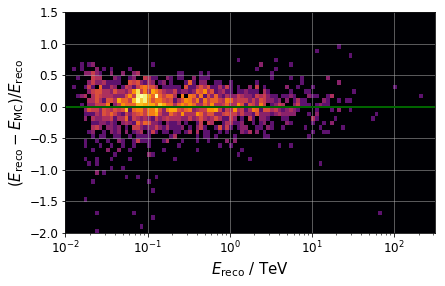

In [15]:
# (reco Energy - MC Energy) / reco Energy vs. reco Energy 2D histograms
fig, ax = plt.subplots(1, 1)
counts, _, _ = np.histogram2d(
            energy_rec, (energy_rec - energy_mc) / energy_rec,
            bins=(e_bin_fine_edges, np.linspace(-2, 1.5, 50)))
ax.pcolormesh(e_bin_fine_edges.value, np.linspace(-2, 1.5, 50),
              np.sqrt(counts.T))
plt.plot(e_bin_fine_edges.value[[0, -1]], [0, 0],
         color="darkgreen")
ax.set_xlabel(r"$E_\mathrm{reco}$ / TeV")
ax.set_ylabel(r"$(E_\mathrm{reco} - E_\mathrm{MC}) / E_\mathrm{reco}$")
ax.set_xscale("log")
plt.grid()

plt.subplots_adjust(left=.1, wspace=.1)
plt.show()

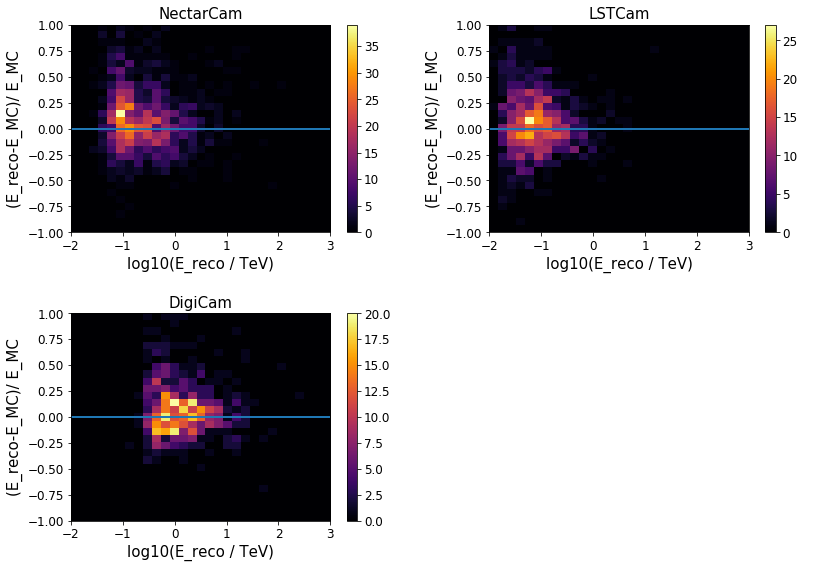

In [16]:
import numpy as np

NBins = 30
relE_Err_hist = {}
relE_bins = np.stack((np.linspace(-1, 1, NBins),
                      np.linspace(-2, 3, NBins)))

for cam_id in reg.model_dict:
    relE_Err_hist[cam_id] = np.histogram2d([], [], bins=relE_bins)[0]

for rece, mce in zip(energy_rec_cam, energy_mc):
    for evt in rece:
        for cam_id, pred in evt.items():
            pred = np.array(pred)
            relE_Err_hist[cam_id] += np.histogram2d([(pred-mce)/mce],
                                            [np.log10(pred)],
                                            bins=relE_bins)[0]

fig, axs = plt.subplots(figsize=(12, 9), nrows=2, ncols=2)
for i, (cam_id, thishist) in enumerate(relE_Err_hist.items()):
    plt.sca(axs.ravel()[i])
    plt.imshow(thishist, interpolation='none', origin='lower',
               extent=[*relE_bins[1, [0, -1]], *relE_bins[0, [0, -1]]],
               aspect="auto")
    plt.plot(relE_bins[1, [0, -1]], (0, 0))
    plt.xlabel('log10(E_reco / TeV)')
    plt.ylabel('(E_reco-E_MC)/ E_MC')
    plt.title(cam_id)
    plt.colorbar()

for j in range(i+1, len(axs.ravel())):
    axs.ravel()[j].axis('off')
    
plt.subplots_adjust(left=0.11, right=0.97, hspace=0.39, wspace=0.29)
        
plt.show()

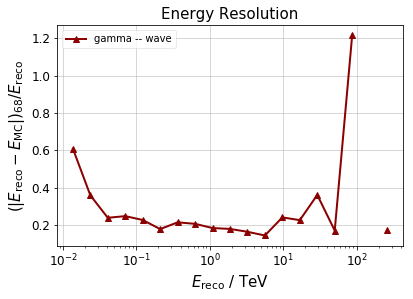

In [17]:
rel_DeltaE_w = np.abs(energy_rec - energy_mc) / energy_rec
DeltaE68_w_ebinned = percentiles(rel_DeltaE_w, energy_rec,
                                 e_bin_edges.value, 68)
plt.figure()
plt.plot(e_bin_centres.value, DeltaE68_w_ebinned, label="gamma -- wave",
         marker='^', color="darkred")
plt.title("Energy Resolution")
plt.xlabel(r"$E_\mathrm{reco}$ / TeV")
plt.ylabel(r"$(|E_\mathrm{reco} - E_\mathrm{MC}|)_{68}/E_\mathrm{reco}$")
plt.gca().set_xscale("log")
plt.grid()
plt.legend()
plt.show()

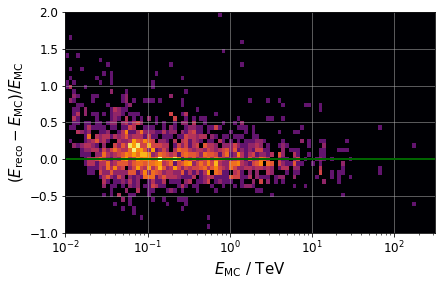

In [18]:
# (reco Energy - MC Energy) / MC Energy vs. MC Energy 2D histograms
fig, ax = plt.subplots(1, 1)
counts, _, _ = np.histogram2d(
            energy_mc,
            (energy_rec - energy_mc) / energy_mc,
            bins=(e_bin_fine_edges, np.linspace(-1, 2, 50)))
ax.pcolormesh(e_bin_fine_edges.value, np.linspace(-1, 2, 50),
              np.sqrt(counts.T))
plt.plot(e_bin_fine_edges.value[[0, -1]], [0, 0],
         color="darkgreen")
ax.set_xlabel(r"$E_\mathrm{MC}$ / TeV")
ax.set_ylabel(r"$(E_\mathrm{reco} - E_\mathrm{MC}) / E_\mathrm{MC}$")
ax.set_xscale("log")
plt.grid()

plt.subplots_adjust(left=.1, wspace=.1)
plt.show()

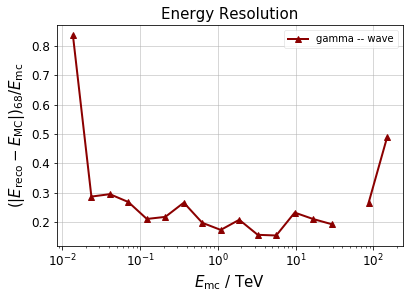

In [19]:
rel_DeltaE_w = np.abs(energy_rec - energy_mc) / energy_mc
DeltaE68_w_ebinned = percentiles(rel_DeltaE_w, energy_mc,
                                 e_bin_edges.value, 68)

plt.figure()
plt.plot(e_bin_centres.value, DeltaE68_w_ebinned, label="gamma -- wave",
         marker='^', color="darkred")
plt.title("Energy Resolution")
plt.xlabel(r"$E_\mathrm{mc}$ / TeV")
plt.ylabel(r"$(|E_\mathrm{reco} - E_\mathrm{MC}|)_{68}/E_\mathrm{mc}$")
plt.gca().set_xscale("log")
plt.grid()
plt.legend()
plt.show()